# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set()

In [2]:
def create_bootstrap_replicate(data, func):
    """Create one bootstrap replicate from a data set using a given function."""
    replicate = func(np.random.choice(data, size=len(data)))
    return replicate

def bootstrap_hypothesis_test(data, func, size=1):
    """Retrun an array of bootstrap replicates with given size and function. """
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = create_bootstrap_replicate(data, func)
    return bs_replicates

def ecdf(data):
    """Compute ECDF for a given set of data."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [3]:
df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


# Question 1
***Is the distribution of body temperatures normal?***

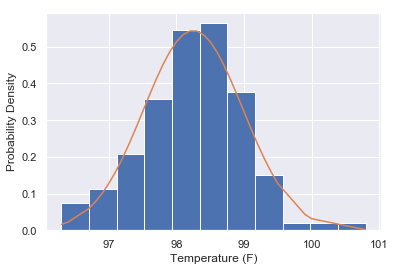

In [4]:
# To check for normality visaully, first view a histogram of the temperature data.
temp_mean = df['temperature'].mean()
temp_std = df['temperature'].std()
sorted_temps = df['temperature'].sort_values()
normal_fit = stats.norm.pdf(sorted_temps, temp_mean, temp_std)
n_rows = len(df.index)
n_bins = int(np.sqrt(n_rows))
plt.hist(df['temperature'], bins = n_bins, density = True)
plt.plot(sorted_temps, normal_fit)
plt.xlabel("Temperature (F)")
plt.ylabel("Probability Density")
plt.show()

In [5]:
# Data looks pretty normal, but let's check to be sure. 
_, SW_pval = stats.shapiro(df.temperature) # Shapiro-Wilk Test
_, KS_pval = stats.kstest(df.temperature, 'norm', args=(temp_mean, temp_std)) # Kolmorgorov-Smirnov Test
_, DP_pval = stats.normaltest(df.temperature) # D'Agostino-Pearson Test
print("Using Shapiro-Wilk Test: p = %f" % SW_pval)
print("Using Kolmorgorov-Smirnov Test: p = %f" % KS_pval)
print("Using D'Agostino-Pearson Test: p = %f" % DP_pval)

Using Shapiro-Wilk Test: p = 0.233175
Using Kolmorgorov-Smirnov Test: p = 0.645031
Using D'Agostino-Pearson Test: p = 0.258748


For each test, the *p* values are > 0.05. As a result we can confirm the null hypothesis and assume that the distribution of temperatures is normal

# Question 2

***Is the sample size large? Are the observations independent?***

In [6]:
df.groupby('gender').count()

,temperature,heart_rate
gender,,
F,65,65
M,65,65


The general rule of thumb is that if n > 30, the central limit theorem will apply. Because the sample in this case is n = 65 + 65 = 130.  we CAN assume that the central limit theorem will apply in this case. We can also rule out any gender bias because the sample population is split evenly among men and women (65 men, 65 women). Furthermore, size of the subpopulations for men and women both exceed 30. 


We can also assume that each of these observations are independent, due to the fact that a sample size of 130 is definitely less than 10% of entire population of men and women.

# Question 3
***Is the true population mean really 98.6 degrees F?***


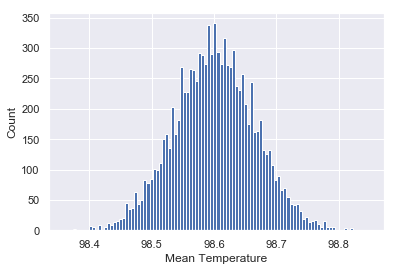

mean temperature from dataset: 98.249231
p-value for bootstrap hypothesis test: 0.000000


In [7]:
# First, we do a bootsrap hypothesis test:
# Null hypothesis: The true mean of human body temperature is 98.6 degrees. 
temps = df['temperature'].values
temp_mean = np.mean(temps)
shifted_temps = temps - temp_mean + 98.6
mean_temp_bs_reps = bootstrap_hypothesis_test(shifted_temps, np.mean, size = 10000)
p = np.sum(mean_temp_bs_reps <= temp_mean) / len(mean_temp_bs_reps)
_ = plt.hist(mean_temp_bs_reps, bins = 100)
_ = plt.xlabel('Mean Temperature')
_ = plt.ylabel('Count')
plt.show()
print('mean temperature from dataset: %f' %temp_mean)
print('p-value for bootstrap hypothesis test: %f' % p)

The result of the bootstrap hypothesis test shown above show that there was not one bootstrap replicate that had a mean less than the actual mean from the data set (approximately 98.25). As such, the bootstrap hypothesis test resulted in a p value of 0. This means that we can reject the null hypothesis, and conclude that is it extremely unlikely that we would generate this data set if the actual mean body temperature is 98.6 degrees. 

***Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?***

Since we are comparing a dataset to a single value (the supposed human body temperature mean of 98.6 degrees), we should complete a one sample test

***In this situation, is it appropriate to use the  𝑡  or  𝑧  statistic?***

Well, in order to calculate the z statistic we would need the standard deviation of the mean body temperatures for the entire population, which we do not have. As such, we should calculate the t statistic. 

In [8]:
t_stat, p_value = stats.ttest_1samp(temps, 98.6)
print('Value of t-statistic: %f' % t_stat)
print('p-value: %f' % p_value)

Value of t-statistic: -5.454823
p-value: 0.000000


Once again, our test resulted in a p-value of 0, indicating that we can reject the null hypothesis and assume that it would be highly unlikely to acquire the given dataset if the true population mean was actually 98.6

***Now try using the other test. How is the result be different? Why?***

Once again, since we do not know the population standard deviation, we cannot perform a z test

# Question 4
***Draw a small sample of size 10 from the data and repeat both frequentist tests.***

In [9]:
resample = np.random.choice(temps, size = 10)
t_stat, p_value = stats.ttest_1samp(resample, 98.6)
print('Value of t-statistic: %f' % t_stat)
print('p-value: %f' % p_value)

Value of t-statistic: -0.301511
p-value: 0.769875


As seen above, doing the 1 sample t test with a resampled dataset only including 10 temperatures gave us a p value > 0.05. As such we can no longer reject the null hypothesis and conclude that the true population mean is not equal to 98.6 degrees. This goes to show that it is better to perform hypothesis testing with a larger sample population. Indeed, if we repeat the process shown above many times (as shown below), we get a large variability in the p value.

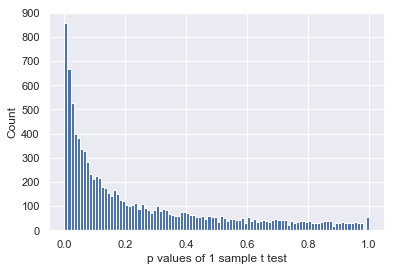

In [10]:
p_values = np.empty(10000)
for i in range(10000):
    resample = np.random.choice(temps, size = 10)
    t_stat, p_value = stats.ttest_1samp(resample, 98.6)
    p_values[i] = p_value

_ = plt.hist(p_values, bins = 100)
_ = plt.xlabel('p values of 1 sample t test')
_ = plt.ylabel('Count')
plt.show()

# Question 5:
***At what temperature should we consider someone's temperature to be "abnormal"?***

***As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.***

In [11]:
# Using bootstrap method:
temp_means = bootstrap_hypothesis_test(temps, np.mean, size = 10000)
# I will use the quartile definition of an outlier to determine temperatures that are abnormal.
# More specifically any temperatures that are more than 1.5 times the IQR below Q1 or above Q3 will are 'abnormal'.
Q1, Q3 = np.percentile(temp_means, [25, 75])
IQR = Q3 - Q1
min_normal = Q1 - (1.5 * IQR)
max_normal = Q3 + (1.5 * IQR)
print('Normal Temperature Range: %3.2f - %3.2f' % (min_normal, max_normal))

Normal Temperature Range: 98.08 - 98.42


# Question 6
***Is there a significant difference between males and females in normal temperature?***


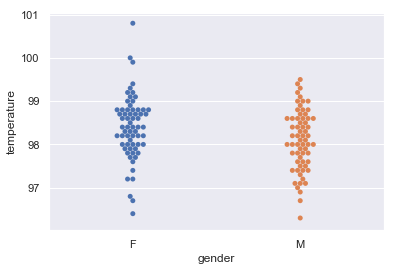

In [12]:
# First do some EDA:
_ = sns.swarmplot(x=df['gender'], y=df['temperature'], data=df)

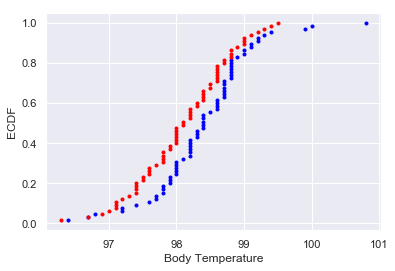

In [13]:
temps_f = df['temperature'][df['gender'] == 'F'].values
temps_m = df['temperature'][df['gender'] == 'M'].values
x_f, y_f = ecdf(temps_f)
x_m, y_m = ecdf(temps_m)
_ = plt.plot(x_f, y_f, marker='.', color='blue', linestyle='none')
_ = plt.plot(x_m, y_m, marker='.', color='red', linestyle='none')
_ = plt.xlabel('Body Temperature')
_ = plt.ylabel('ECDF')
plt.show()

Based on the two graphical representations of the data, we can see that there might indeed be a difference between the two genders when it comes to body temperature. Let's now test this by first doing a bootstrap hypothesis test for the difference between the two means. 

In [14]:
# Bootstrap hypothesis test
# Null hypothesis: The mean body temperature for men and women is the same. 
combined_mean = np.mean(np.concatenate((temps_f, temps_m)))
temps_f_shifted = temps_f - np.mean(temps_f) + combined_mean
temps_m_shifted = temps_m - np.mean(temps_m) + combined_mean
bs_reps_f = bootstrap_hypothesis_test(temps_f_shifted, np.mean, size = 10000)
bs_reps_m = bootstrap_hypothesis_test(temps_m_shifted, np.mean, size = 10000)
mean_differences = bs_reps_m - bs_reps_f
p_value = np.sum(mean_differences > (np.mean(temps_f) - np.mean(temps_m))) / len(mean_differences)
print('p-value: %f' % p_value)

p-value: 0.010300


According to the results of the bootstrap hypothesis test, a comparison of the mean body temperature for both genders results in a p-value of approximately 0.01. Since this result is below 0.05, we can reject the null hypothesis test and conclude that is highly unlikey we would have acquired this data if the mean body temperature for men and women is the same. This is in agreement with the preliminary results of our EDA, which seemed to show that the average body temperature for men was slightly lower than the average body temperature for women. 

In [15]:
t_stat, p_value = stats.ttest_ind(temps_f, temps_m)
print('t statistic: %f' % t_stat)
print('p value: %f' % p_value)

t statistic: 2.285435
p value: 0.023932


Using scipy.stats' independent samples t test confirms the results of the bootstrap hypothesis test, resulting in a value of approximately 0.024.